In [1]:
# Import needed libraries
import os
import scipy
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from sklearn import metrics
import statsmodels.api as sm
from datetime import timedelta
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from sklearn import preprocessing
from matplotlib.pyplot import xticks
from sklearn.metrics import roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, learning_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import explained_variance_score, r2_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier

# Data display coustomization
sns.set(style="white")
plt.rc("font", size=14)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
sns.set(style="whitegrid", color_codes=True)

In [2]:
# Load data and check size of raw data
leadData = pd.read_excel("Credit Reject Data Request.xlsx", sheet_name = 'Detail Data Set')
leadData.shape

(441667, 20)

**Filter data**

The credit reject field contains values of 0 & 1. 1= credit was rejected. However the credit reject data represents 3 scenarios

A. Lead where we never got a hold of Credit reject = 0

B. Lead we contacted but never ran their credit, Reject = 0

C. Lead we contacted and ran their credit Reject = 0 or 1.

We are going to filter the data set where Gross Sales =1. When Gross Sales =1, this means the Sales team met with the customer.

In [3]:
# Apply filter to Gross Sale column - Set to 1
df = leadData[(leadData['GrossSale'] == 1)]
df['Days_Difference'] = (df['AppointmentDate'] - df['LeadCreationDate']).dt.days
ds = df[['LeadID','LeadSourceCategory','LeadSourceGroup','ProductName','CustomerCity','CustomerState','CustomerZip',
         'ExperianSegment','Days_Difference','NetSale','GrossVolume','CreditReject']]
ds.shape

(80998, 12)

Class 0: 62267
Class 1: 18731
Proportion: 3.32 : 1


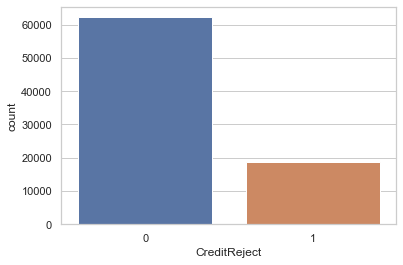

In [4]:
# Check the CreditReject distributions
CreditReject_Count = ds.CreditReject.value_counts()
print('Class 0:', CreditReject_Count[0])
print('Class 1:', CreditReject_Count[1])
print('Proportion:', round(CreditReject_Count[0] / CreditReject_Count[1], 2), ': 1')

sns.countplot("CreditReject",data=ds)

In [5]:
# Check total count of missing values in each column
ds.isnull().sum()

LeadID                   0
LeadSourceCategory       0
LeadSourceGroup          0
ProductName              0
CustomerCity             1
CustomerState            0
CustomerZip              0
ExperianSegment       8867
Days_Difference          0
NetSale                  0
GrossVolume              0
CreditReject             0
dtype: int64

In [6]:
# Check for percentage of missing values
missingValues_percentage = round(100*(ds.isnull().sum()/len(ds.index)), 2)
missingValues_percentage

LeadID                 0.00
LeadSourceCategory     0.00
LeadSourceGroup        0.00
ProductName            0.00
CustomerCity           0.00
CustomerState          0.00
CustomerZip            0.00
ExperianSegment       10.95
Days_Difference        0.00
NetSale                0.00
GrossVolume            0.00
CreditReject           0.00
dtype: float64

In [7]:
mean_ES = round(ds['ExperianSegment'].mean(),2)
mean_ES

5.31

In [8]:
# Fill missings values columns since they are less than 15% (Standard data mining procedure)
ds['CustomerCity'] = ds['CustomerCity'].fillna('Unkwon')
ds['ExperianSegment'] = ds['ExperianSegment'].fillna(mean_ES)

In [9]:
# Confirm
ds.isnull().sum()

LeadID                0
LeadSourceCategory    0
LeadSourceGroup       0
ProductName           0
CustomerCity          0
CustomerState         0
CustomerZip           0
ExperianSegment       0
Days_Difference       0
NetSale               0
GrossVolume           0
CreditReject          0
dtype: int64

# Feature Engineering

In [10]:
frequency = ds.groupby('CustomerZip').count()['LeadID'] # group zipcodes, and sum up number of Gross Salez
mean = ds.groupby('CustomerZip').mean()['GrossVolume'] # get mean Gross Volume Salez
cluster = pd.concat([frequency, mean], axis=1) # combine these
cluster['CustomerZip'] = cluster.index
cluster.columns = ['frequency', 'GrossVolume', 'CustomerZip']
cluster.describe()

,frequency,GrossVolume,CustomerZip
count,12610.000000,12610.000000,12610.000000
mean,6.423315,10395.472415,50593.472799
std,9.349110,4281.816713,28418.596077
min,1.000000,1018.910000,601.000000
25%,1.000000,7860.886771,28409.500000
50%,3.000000,9860.927000,47141.000000
75%,8.000000,12220.026250,76007.500000
max,166.000000,60011.120000,99403.000000


**Create cluster group for zip codes**

In [11]:
# creating "cheap" group that has Gross Volume below mean (10395)
cluster_cheap = cluster[cluster.GrossVolume < 10395]

# temporary cluster - above mean GrossVolume
cluster_temp = cluster[cluster.GrossVolume >= 10395]

# creating "low volume, higher gross volume" group that has gross volume less frequently than the mean
cluster_expensive_low_volume = cluster_temp[cluster_temp.frequency < 6]

# creating "high volume, higher volume" more frequently than the mean
cluster_expensive_high_volume = cluster_temp[cluster_temp.frequency >= 6]

def get_zipcode_category(zipcode):
    if zipcode in cluster_cheap.index:
        return 'cheap'
    elif zipcode in cluster_expensive_low_volume.index:
        return 'expensive_low_volume'
    else:
        return 'expensive_high_volume' 

ds['zipcode_type'] = ds.CustomerZip.apply(get_zipcode_category)
ds.zipcode_type.value_counts() # view how clusters look    

cheap                    45176
expensive_high_volume    27890
expensive_low_volume      7932
Name: zipcode_type, dtype: int64

In [12]:
# Create dummies (categorical features)

ds['LeadSourceCategory'] = ds['LeadSourceCategory'].astype('category')
LeadSourceCategory = pd.get_dummies(ds['LeadSourceCategory'], prefix='leadscat', drop_first=True)

ds['LeadSourceGroup'] = ds['LeadSourceGroup'].astype('category')
LeadSourceGroup = pd.get_dummies(ds['LeadSourceGroup'], prefix='leadsgrp', drop_first=True)

ds['ProductName'] = ds['ProductName'].astype('category')
ProductName = pd.get_dummies(ds['ProductName'], prefix='prdName', drop_first=True)

ds['CustomerCity'] = ds['CustomerCity'].astype('category')
CustomerCity = pd.get_dummies(ds['CustomerCity'], prefix='cuscity', drop_first=True)

ds['CustomerState'] = ds['CustomerState'].astype('category')
CustomerState = pd.get_dummies(ds['CustomerState'], prefix='cusstate', drop_first=True)

ds['zipcode_type'] = ds['zipcode_type'].astype('category')
zip_d = pd.get_dummies(ds['zipcode_type'], prefix='zp', drop_first=True)

# adding these new categories to our dataframe
data = pd.concat([ds,LeadSourceCategory,LeadSourceGroup,ProductName,CustomerCity,CustomerState,zip_d], axis=1)

# drop old columns.
data.drop(['LeadSourceCategory','LeadSourceGroup','ProductName','CustomerCity','CustomerState',
           'CustomerZip','zipcode_type'], axis=1, inplace=True)

In [13]:
# View few rows.
data.head(2)

,LeadID,ExperianSegment,Days_Difference,NetSale,GrossVolume,CreditReject,leadscat_Centah,leadscat_Direct Mail,leadscat_InStore,leadscat_Inserts,leadscat_Internet #1,leadscat_Internet #2,leadscat_Misc/Self Gen,leadscat_Sears,leadscat_Take The Lead,leadscat_Telemarketing,leadscat_Third Party Fun,leadscat_Yellow Pages,leadsgrp_Armed Forces Exchange,leadsgrp_BuyerLink,leadsgrp_CCN Networks,leadsgrp_Centah Call Center,leadsgrp_Centah Store,leadsgrp_Centah Web,leadsgrp_Customer Communications,leadsgrp_Direct Buy,leadsgrp_Event Marketing,leadsgrp_Google Paid Search,leadsgrp_Home Advisor,leadsgrp_Instore,leadsgrp_MSN Paid Search,leadsgrp_Misc.,leadsgrp_Misc. Inserts,leadsgrp_Modernize,leadsgrp_Natural Search,leadsgrp_Online Display,leadsgrp_Other,leadsgrp_PI Email #2,leadsgrp_PI Internet,leadsgrp_Partner Web Traffic,leadsgrp_Porch,leadsgrp_Promotional Emails,leadsgrp_Prospect Mail,leadsgrp_QuinStreet,leadsgrp_RMI,leadsgrp_Radio,leadsgrp_Red Ventures,leadsgrp_Search Internet Tests,leadsgrp_Sears,leadsgrp_Sears Associate TTL,...,cuscity_village mills,cuscity_woodland park,cusstate_AR,cusstate_AZ,cusstate_Al,cusstate_CA,cusstate_CO,cusstate_CT,cusstate_DC,cusstate_DE,cusstate_FL,cusstate_GA,cusstate_IA,cusstate_ID,cusstate_IL,cusstate_IN,cusstate_KS,cusstate_KY,cusstate_LA,cusstate_MA,cusstate_MD,cusstate_ME,cusstate_MI,cusstate_MN,cusstate_MO,cusstate_MS,cusstate_MT,cusstate_NC,cusstate_NE,cusstate_NJ,cusstate_NM,cusstate_NV,cusstate_NY,cusstate_OH,cusstate_OK,cusstate_OR,cusstate_PA,cusstate_PR,cusstate_RI,cusstate_SC,cusstate_TN,cusstate_TX,cusstate_UT,cusstate_VA,cusstate_WA,cusstate_WI,cusstate_WV,cusstate_WY,zp_expensive_high_volume,zp_expensive_low_volume
13,24015555,5.0,91,0,16838.43,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24,24015615,6.0,23,0,14495.71,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [14]:
print("length of training data",len(data))
print("length of normal data",len(data[data["CreditReject"]==0]))
print("length of fraud  data",len(data[data["CreditReject"]==1]))

length of training data 80998
length of normal data 62267
length of fraud  data 18731


In [15]:
# Percentage of accepted and rejected transactions
Count_Normal_transacation = len(data[data["CreditReject"]==0]) # normal transaction are repersented by 0
Count_CreditReject_transacation = len(data[data["CreditReject"]==1]) # Credit Reject by 1
Percentage_of_Normal_transacation = Count_Normal_transacation/(Count_Normal_transacation+Count_CreditReject_transacation)
print("percentage of normal transacation is",round(Percentage_of_Normal_transacation*100,2))
Percentage_of_CreditReject_transacation= Count_CreditReject_transacation/(Count_Normal_transacation+Count_CreditReject_transacation)
print("percentage of Credit Reject transacation",round(Percentage_of_CreditReject_transacation*100,2))

percentage of normal transacation is 76.87
percentage of Credit Reject transacation 23.13


**Handle Imbalance problem - Resampling Technique**

In [16]:
#Down-sample Majority Class

from sklearn.utils import resample
# Separate majority and minority classes
df_majority = data[data.CreditReject==0]
df_minority = data[data.CreditReject==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=18731,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.CreditReject.value_counts()

1    18731
0    18731
Name: CreditReject, dtype: int64

# Build Models - Phase I

In [17]:
# Standridze our GrossVolume column and Days_Difference column
df_downsampled["Normalized Gross Amount"] = StandardScaler().fit_transform(df_downsampled['GrossVolume'].values.reshape(-1, 1))
df_downsampled["Normalized Days"] = StandardScaler().fit_transform(df_downsampled['Days_Difference'].values.reshape(-1, 1))
df_downsampled["Normalized ExperianSegment"] = StandardScaler().fit_transform(df_downsampled['ExperianSegment'].values.reshape(-1, 1))
df_downsampled.drop(["LeadID","GrossVolume","Days_Difference","ExperianSegment"],axis=1,inplace=True)

In [18]:
# Train a model using Logistic Regression - Undersampled data set

# Separate input features (X) and target variable (y)
y = df_downsampled.CreditReject
X = df_downsampled.drop('CreditReject', axis=1)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)

# Train model
#logistic_regression = LogisticRegression(solver='liblinear', random_state=0) #Other options are 'newton-cg', 'lbfgs', 'sag', and 'saga'

logistic_regression= LogisticRegression()
logistic_regression.fit(X_train,y_train)
y_pred=logistic_regression.predict(X_test)

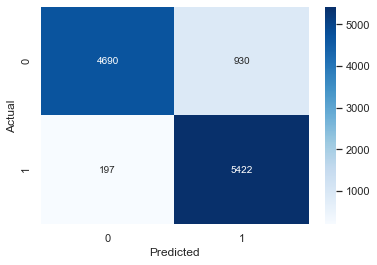

In [19]:
# Model validation with Confusion Matrix - Undersampled data without feature selection 
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix,annot=True,cmap='Blues', fmt='g')

**Confusion Matrix Interpretation**

The above result is telling us that we have 4687+5420 correct predictions and 933+199 incorrect predictions

In [20]:
print('Accuracy: ',round(metrics.accuracy_score(y_test, y_pred),3))
plt.show()

Accuracy:  0.9


In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.83      0.89      5620
           1       0.85      0.96      0.91      5619

    accuracy                           0.90     11239
   macro avg       0.91      0.90      0.90     11239
weighted avg       0.91      0.90      0.90     11239



## Over-sampling using SMOTE Algorithm

**Synthetic Minority Oversampling Technique**

In [22]:
import timeit
tic=timeit.default_timer() # Check processing time

data_final = data.copy()

# Standridze our GrossVolume column and Days_Difference column
data_final["Normalized Gross Amount"] = StandardScaler().fit_transform(data_final['GrossVolume'].values.reshape(-1, 1))
data_final["Normalized Days"] = StandardScaler().fit_transform(data_final['Days_Difference'].values.reshape(-1, 1))
data_final["Normalized ExperianSegment"] = StandardScaler().fit_transform(data_final['ExperianSegment'].values.reshape(-1, 1))
data_final.drop(["LeadID","GrossVolume","Days_Difference","ExperianSegment"],axis=1,inplace=True)

X = data_final.loc[:, data_final.columns != 'CreditReject']
y = data_final.loc[:, data_final.columns == 'CreditReject']

os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['CreditReject'])

print("length of oversampled data is ",len(os_data_X))
print("Number of Credit Accept in oversampled data",len(os_data_y[os_data_y['CreditReject']==0]))
print("Number of Credit Reject",len(os_data_y[os_data_y['CreditReject']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['CreditReject']==0])/len(os_data_X))
print("Proportion of Credit Reject data in oversampled data is ",len(os_data_y[os_data_y['CreditReject']==1])/len(os_data_X))

toc=timeit.default_timer()
Elapsed = toc - tic 
hours, rem = divmod(Elapsed, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

length of oversampled data is  87158
Number of Credit Accept in oversampled data 43579
Number of Credit Reject 43579
Proportion of no subscription data in oversampled data is  0.5
Proportion of Credit Reject data in oversampled data is  0.5
00:35:28.40


**Logistic Regression with Oversampled data**

In [23]:
X = pd.DataFrame(data=os_data_X,columns=columns )
y = pd.DataFrame(data=os_data_y,columns=['CreditReject'])

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
os_lr = LogisticRegression()
os_lr.fit(X_train,y_train)
os_pred = os_lr.predict(X_test)

print('Accuracy:',round(metrics.accuracy_score(y_test, os_pred)*100,1))
plt.show()

Accuracy: 92.2


# Feature Selection

In [24]:
# Feature Extraction with Univariate Statistical Tests

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.datasets import load_digits

X_oversampled = pd.DataFrame(data=os_data_X,columns=columns )
y_oversampled = pd.DataFrame(data=os_data_y,columns=['CreditReject'])

X_train,X_test,y_train,y_test = train_test_split(X_oversampled,y_oversampled,test_size=0.3,random_state=42)

names=pd.DataFrame(X_train.columns)

model = SelectKBest(score_func=f_regression, k=4)
results = model.fit(X_oversampled, y_oversampled)

results_df=pd.DataFrame(results.scores_)
#Concat and name columns
scored=pd.concat([names,results_df], axis=1)
scored.columns = ["Feature", "Score"]
scored.sort_values(by=['Score'], ascending = False).head(10)

,Feature,Score
0,NetSale,164222.159974
10837,Normalized ExperianSegment,16637.341032
63,leadsgrp_Warm Transfer Programs,3778.136061
10790,cusstate_CA,2973.634987
28,leadsgrp_Modernize,2006.034182
23,leadsgrp_Home Advisor,2003.963712
6,leadscat_Internet #2,1391.915049
76,prdName_Roofing,777.886502
10791,cusstate_CO,724.052067
54,leadsgrp_Tech Leads,710.485198


In [25]:
print(results.scores_)

[1.64222160e+05 1.58934377e+02 7.06700622e+01 ... 5.69529920e+02
 5.70153350e+01 1.66373410e+04]


**Feature Extraction with Lasso L1**

In [26]:
X_lasso = pd.DataFrame(data=os_data_X,columns=columns )
y_lasso = pd.DataFrame(data=os_data_y,columns=['CreditReject'])

X_train,X_test,y_train,y_test = train_test_split(X_lasso,y_lasso,test_size=0.3,random_state=42)

clf = LogisticRegression(C=0.01, penalty='l1',solver='liblinear')
clf.fit(X_train,y_train)
pred = clf.predict(X_test)
print('Non Zero weights:',np.count_nonzero(clf.coef_))

Non Zero weights: 18


In [27]:
#Selecting features using Lasso regularisation with SelectFromModel algo

X_lasso2 = pd.DataFrame(data=os_data_X,columns=columns )
y_lasso2 = pd.DataFrame(data=os_data_y,columns=['CreditReject'])

X_train,X_test,y_train,y_test = train_test_split(X_lasso2,y_lasso2,test_size=0.3,random_state=42)

lasso2 = SelectFromModel(LogisticRegression(C=0.1, penalty='l1',solver='liblinear'))
lasso2.fit(X_train, y_train)

selectedFeature = X_train.columns[(lasso2.get_support())]
#np.sum(lasso.estimator_.coef_ == 0)
print('Total features: {}'.format((X_train.shape[1])))
print('Selected features: {}'.format(len(selectedFeature)))
print('Features with coefficients shrank to zero: {}'.format(
    np.sum(lasso2.estimator_.coef_ == 0)))

Total features: 10838
Selected features: 82
Features with coefficients shrank to zero: 10756


In [28]:
#Identify the penalized coefficients (removed features)

removed_features = X_train.columns[(lasso2.estimator_.coef_ == 0).ravel().tolist()]
removed_features = pd.DataFrame(removed_features)
removed_features.head()

,0
0,leadscat_Centah
1,leadscat_Direct Mail
2,leadscat_InStore
3,leadscat_Inserts
4,leadscat_Misc/Self Gen


In [29]:
#Identify the retained features

retained_features = X_train.columns[(lasso2.estimator_.coef_ != 0).ravel().tolist()]
retained_features = pd.DataFrame(retained_features, columns = ['Selected_Features'])
retained_features.head()

,Selected_Features
0,NetSale
1,leadscat_Internet #1
2,leadscat_Internet #2
3,leadsgrp_CCN Networks
4,leadsgrp_Google Paid Search


In [30]:
retained_features.Selected_Features.value_counts()

leadsgrp_Porch                     1
cusstate_UT                        1
cusstate_NY                        1
prdName_Roofing                    1
Normalized Gross Amount            1
prdName_HVAC                       1
prdName_Windows                    1
leadsgrp_CCN Networks              1
cusstate_NC                        1
leadsgrp_Google Paid Search        1
leadsgrp_Warm Transfer Programs    1
cusstate_WA                        1
prdName_Siding                     1
NetSale                            1
leadsgrp_Natural Search            1
prdName_Flooring                   1
leadsgrp_Home Advisor              1
Normalized ExperianSegment         1
cusstate_LA                        1
leadscat_Internet #1               1
prdName_Kitchens                   1
cusstate_AR                        1
leadsgrp_Modernize                 1
zp_expensive_high_volume           1
cusstate_FL                        1
cusstate_TX                        1
cusstate_IL                        1
c

# Build Model with Selected Features

In [28]:
#X = pd.DataFrame(data=os_data_X,columns=columns)
df_X = os_data_X[['leadsgrp_Porch','cusstate_UT','cusstate_NY','prdName_Roofing','Normalized Gross Amount',
                  'prdName_HVAC','prdName_Windows','leadsgrp_CCN Networks','cusstate_NC',
                  'leadsgrp_Google Paid Search','leadsgrp_Warm Transfer Programs','cusstate_WA',
                  'prdName_Siding','NetSale','leadsgrp_Natural Search','prdName_Flooring',
                  'leadsgrp_Home Advisor','Normalized ExperianSegment','cusstate_LA','leadscat_Internet #1',
                  'prdName_Kitchens','cusstate_AR','leadsgrp_Modernize','zp_expensive_high_volume','cusstate_FL',
                  'cusstate_TX','cusstate_IL','cusstate_CA','leadscat_Internet #2','Normalized Days']]

y = pd.DataFrame(data=os_data_y,columns=['CreditReject'])

X_train,X_test,y_train,y_test = train_test_split(df_X,y,test_size=0.3,random_state=42)
os_lr = LogisticRegression()
os_lr.fit(X_train,y_train)
os_pred = os_lr.predict(X_test)

print('Accuracy:',round(metrics.accuracy_score(y_test, os_pred)*100,1))
plt.show()

Accuracy: 91.0


In [29]:
# Check scores on Training data set
os_pred2 = os_lr.predict(X_train)

print('Accuracy:',round(metrics.accuracy_score(y_train, os_pred2)*100,1))
plt.show()

Accuracy: 91.0


## ROC Curve

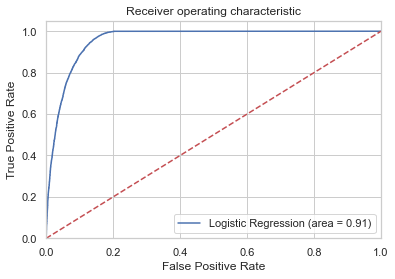

In [30]:
logit_roc_auc = roc_auc_score(y_test, os_lr.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, os_lr.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

In [71]:
#Random Forest Model

# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)

rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)

print('Accuracy:',round(metrics.accuracy_score(y_test, rf_pred)*100,1))
plt.show()

Accuracy: 89.8


**Repeat this steps to ensure that P-values for all the predictors are significant - 95% confidence level (P-Value <0.05)**

In [32]:
glm = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
glm.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           CreditReject   No. Observations:                61010
Model:                            GLM   Df Residuals:                    60979
Model Family:                Binomial   Df Model:                           30
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13484.
Date:                Thu, 16 Jul 2020   Deviance:                       26968.
Time:                        21:31:53   Pearson chi2:                 3.92e+04
No. Iterations:                    29                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               1.2903      0.045     28.532      0.000       1.202       1.379
leadsgrp_Porch                      0.1654      0.129      1.284      0.199      -0.087       0.418
cusstate_UT                        -1.1342      0.140     -8.089      0.000      -1.409      -0.859
cusstate_NY                        -0.5695      0.066     -8.628      0.000      -0.699      -0.440
prdName_Roofing                    -0.0392      0.059     -0.668      0.504      -0.154       0.076
Normalized Gross Amount             0.3653      0.019     19.126      0.000       0.328       0.403
prdName_HVAC                        0.4806      0.046     10.346      0.000       0.390       0.572
prdName_Windows                     0.0480      0.053      0.901      0.368      -0.056       0.152
leadsgrp_CCN Networks               0.1474      0.048      3.089      0.002       0.054       0.241
cusstate_NC                         0.0840      0.074      1.128      0.259      -0.062       0.230
leadsgrp_Google Paid Search         0.2311      0.095      2.427      0.015       0.044       0.418
leadsgrp_Warm Transfer Programs     0.8179      0.092      8.881      0.000       0.637       0.998
cusstate_WA                        -1.3472      0.106    -12.694      0.000      -1.555      -1.139
prdName_Siding                     -0.9875      0.079    -12.500      0.000      -1.142      -0.833
NetSale                           -32.0647   1.54e+04     -0.002      0.998   -3.02e+04    3.01e+04
leadsgrp_Natural Search            -0.3156      0.098     -3.218      0.001      -0.508      -0.123
prdName_Flooring                   -0.1798      0.085     -2.127      0.033      -0.345      -0.014
leadsgrp_Home Advisor              -0.9227      0.098     -9.437      0.000      -1.114      -0.731
Normalized ExperianSegment         -0.9298      0.020    -46.924      0.000      -0.969      -0.891
cusstate_LA                         0.0077      0.115      0.067      0.947      -0.217       0.233
leadscat_Internet #1                0.6476      0.094      6.882      0.000       0.463       0.832
prdName_Kitchens                   -0.8766      0.080    -10.950      0.000      -1.034      -0.720
cusstate_AR                         0.4921      0.167      2.954      0.003       0.166       0.819
leadsgrp_Modernize                  0.2541      0.103      2.473      0.013       0.053       0.456
zp_expensive_high_volume           -0.1178      0.038     -3.117      0.002      -0.192      -0.044
cusstate_FL                        -0.6410      0.080     -7.987      0.000      -0.798      -0.484
cusstate_TX                        -0.1459      0.055     -2.651      0.008      -0.254      -0.038
cusstate_IL                        -0.5551      0.078     -7.090      0.000      -0

In [33]:
#Feature Selection Using RFE
rfeLogic = LogisticRegression()
rfe = RFE(rfeLogic, 25)             #running RFE with 25 variables as output
rfe = rfe.fit(X_train, y_train)

In [34]:
rfe.support_

array([ True,  True,  True, False,  True,  True, False,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False])

In [35]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('leadsgrp_Porch', True, 1),
 ('cusstate_UT', True, 1),
 ('cusstate_NY', True, 1),
 ('prdName_Roofing', False, 4),
 ('Normalized Gross Amount', True, 1),
 ('prdName_HVAC', True, 1),
 ('prdName_Windows', False, 3),
 ('leadsgrp_CCN Networks', True, 1),
 ('cusstate_NC', False, 2),
 ('leadsgrp_Google Paid Search', True, 1),
 ('leadsgrp_Warm Transfer Programs', True, 1),
 ('cusstate_WA', True, 1),
 ('prdName_Siding', True, 1),
 ('NetSale', True, 1),
 ('leadsgrp_Natural Search', True, 1),
 ('prdName_Flooring', True, 1),
 ('leadsgrp_Home Advisor', True, 1),
 ('Normalized ExperianSegment', True, 1),
 ('cusstate_LA', False, 6),
 ('leadscat_Internet #1', True, 1),
 ('prdName_Kitchens', True, 1),
 ('cusstate_AR', True, 1),
 ('leadsgrp_Modernize', True, 1),
 ('zp_expensive_high_volume', True, 1),
 ('cusstate_FL', True, 1),
 ('cusstate_TX', True, 1),
 ('cusstate_IL', True, 1),
 ('cusstate_CA', True, 1),
 ('leadscat_Internet #2', True, 1),
 ('Normalized Days', False, 5)]

In [36]:
# Show the 25 variables from RFE methos
col = X_train.columns[rfe.support_]
col

Index(['leadsgrp_Porch', 'cusstate_UT', 'cusstate_NY',
       'Normalized Gross Amount', 'prdName_HVAC', 'leadsgrp_CCN Networks',
       'leadsgrp_Google Paid Search', 'leadsgrp_Warm Transfer Programs',
       'cusstate_WA', 'prdName_Siding', 'NetSale', 'leadsgrp_Natural Search',
       'prdName_Flooring', 'leadsgrp_Home Advisor',
       'Normalized ExperianSegment', 'leadscat_Internet #1',
       'prdName_Kitchens', 'cusstate_AR', 'leadsgrp_Modernize',
       'zp_expensive_high_volume', 'cusstate_FL', 'cusstate_TX', 'cusstate_IL',
       'cusstate_CA', 'leadscat_Internet #2'],
      dtype='object')

In [37]:
X_train.columns[~rfe.support_]

Index(['prdName_Roofing', 'prdName_Windows', 'cusstate_NC', 'cusstate_LA',
       'Normalized Days'],
      dtype='object')

In [38]:
# Build model with the selected features and check for statistic significance (P-Value < 0.05)
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           CreditReject   No. Observations:                61010
Model:                            GLM   Df Residuals:                    60984
Model Family:                Binomial   Df Model:                           25
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13488.
Date:                Thu, 16 Jul 2020   Deviance:                       26977.
Time:                        21:32:38   Pearson chi2:                 3.92e+04
No. Iterations:                    29                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               1.2990      0.036     36.027      0.000       1.228       1.370
leadsgrp_Porch                      0.1675      0.129      1.302      0.193      -0.085       0.420
cusstate_UT                        -1.1335      0.140     -8.108      0.000      -1.407      -0.859
cusstate_NY                        -0.5727      0.065     -8.744      0.000      -0.701      -0.444
Normalized Gross Amount             0.3565      0.018     19.641      0.000       0.321       0.392
prdName_HVAC                        0.4761      0.036     13.106      0.000       0.405       0.547
leadsgrp_CCN Networks               0.1502      0.048      3.152      0.002       0.057       0.244
leadsgrp_Google Paid Search         0.2338      0.095      2.456      0.014       0.047       0.420
leadsgrp_Warm Transfer Programs     0.8334      0.091      9.117      0.000       0.654       1.013
cusstate_WA                        -1.3547      0.106    -12.794      0.000      -1.562      -1.147
prdName_Siding                     -0.9883      0.073    -13.484      0.000      -1.132      -0.845
NetSale                           -32.0654   1.54e+04     -0.002      0.998   -3.02e+04    3.01e+04
leadsgrp_Natural Search            -0.3111      0.098     -3.176      0.001      -0.503      -0.119
prdName_Flooring                   -0.1911      0.080     -2.388      0.017      -0.348      -0.034
leadsgrp_Home Advisor              -0.9354      0.097     -9.683      0.000      -1.125      -0.746
Normalized ExperianSegment         -0.9280      0.020    -47.015      0.000      -0.967      -0.889
leadscat_Internet #1                0.6621      0.093      7.117      0.000       0.480       0.844
prdName_Kitchens                   -0.8783      0.075    -11.732      0.000      -1.025      -0.732
cusstate_AR                         0.4906      0.166      2.950      0.003       0.165       0.817
leadsgrp_Modernize                  0.2531      0.103      2.465      0.014       0.052       0.454
zp_expensive_high_volume           -0.1151      0.038     -3.051      0.002      -0.189      -0.041
cusstate_FL                        -0.6487      0.080     -8.120      0.000      -0.805      -0.492
cusstate_TX                        -0.1488      0.054     -2.738      0.006      -0.255      -0.042
cusstate_IL                        -0.5571      0.078     -7.156      0.000      -0.710      -0.405
cusstate_CA                        -1.4352      0.055    -26.151      0.000      -1.543      -1.328
leadscat_Internet #2                0.1253      0.076      1.645      0.100      -0.024       0.275
===================================================================================================
"""

In [39]:
col1 = col.drop('NetSale',1) # Drop 'NetSale' variable - It's P-Value of 0.998 is greater the significant level.
X_train_sm = sm.add_constant(X_train[col1])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           CreditReject   No. Observations:                61010
Model:                            GLM   Df Residuals:                    60985
Model Family:                Binomial   Df Model:                           24
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -33354.
Date:                Thu, 16 Jul 2020   Deviance:                       66708.
Time:                        21:33:03   Pearson chi2:                 6.15e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.3483      0.022    -15.809      0.000      -0.392      -0.305
leadsgrp_Porch                      0.2677      0.076      3.535      0.000       0.119       0.416
cusstate_UT                        -1.3513      0.101    -13.336      0.000      -1.550      -1.153
cusstate_NY                        -0.4088      0.045     -9.046      0.000      -0.497      -0.320
Normalized Gross Amount             0.3870      0.011     35.062      0.000       0.365       0.409
prdName_HVAC                        0.2560      0.021     12.003      0.000       0.214       0.298
leadsgrp_CCN Networks               0.2970      0.030     10.041      0.000       0.239       0.355
leadsgrp_Google Paid Search         0.2873      0.055      5.191      0.000       0.179       0.396
leadsgrp_Warm Transfer Programs     1.0893      0.053     20.549      0.000       0.985       1.193
cusstate_WA                        -1.1206      0.084    -13.396      0.000      -1.285      -0.957
prdName_Siding                     -0.9816      0.050    -19.731      0.000      -1.079      -0.884
leadsgrp_Natural Search            -0.3983      0.059     -6.729      0.000      -0.514      -0.282
prdName_Flooring                   -0.3153      0.053     -5.929      0.000      -0.420      -0.211
leadsgrp_Home Advisor              -1.0284      0.059    -17.515      0.000      -1.143      -0.913
Normalized ExperianSegment         -0.8441      0.011    -74.480      0.000      -0.866      -0.822
leadscat_Internet #1                0.8931      0.055     16.126      0.000       0.785       1.002
prdName_Kitchens                   -0.7397      0.053    -13.999      0.000      -0.843      -0.636
cusstate_AR                         0.5587      0.090      6.194      0.000       0.382       0.736
leadsgrp_Modernize                  0.2509      0.060      4.183      0.000       0.133       0.369
zp_expensive_high_volume           -0.0849      0.023     -3.705      0.000      -0.130      -0.040
cusstate_FL                        -0.4898      0.050     -9.712      0.000      -0.589      -0.391
cusstate_TX                        -0.2813      0.030     -9.336      0.000      -0.340      -0.222
cusstate_IL                        -0.6166      0.047    -13.181      0.000      -0.708      -0.525
cusstate_CA                        -1.2386      0.040    -31.117      0.000      -1.317      -1.161
leadscat_Internet #2                0.2361      0.045      5.237      0.000       0.148       0.325
===================================================================================================
"""

The rest variables are fine. Re-run model with these variables.

In [40]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:5]

61143    0.652108
30660    0.082341
72243    0.868532
62159    0.586112
82207    0.934908
dtype: float64

In [41]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:5]

array([0.65210804, 0.08234113, 0.86853153, 0.58611222, 0.93490837])

In [88]:
#Creating a dataframe with the actual credit reject flag and the predicted probabilities
#y_train_pred_final = pd.DataFrame({'Credit Reject':y_train.values, 'Credit_Reject_Prob':y_train_pred})
#y_train_pred_final['ID'] = y_train.index
#y_train_pred_final.head()

In [ ]:
y_train_pred_final['predicted'] = y_train_pred_final.Converted_prob.map(lambda x: 0 if x > 0.5 else 1)

# Let's see the head
y_train_pred_final.head()

In [43]:
vif = pd.DataFrame()
vif['Features'] = X_train[col1].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col1].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
15,prdName_Kitchens,10.11
13,Normalized ExperianSegment,5.31
18,zp_expensive_high_volume,4.60
7,leadsgrp_Warm Transfer Programs,3.34
6,leadsgrp_Google Paid Search,2.25
0,leadsgrp_Porch,2.01
11,prdName_Flooring,2.01
19,cusstate_FL,1.77
4,prdName_HVAC,1.68
10,leadsgrp_Natural Search,1.67


# Build Final Model

In [46]:
final = data.copy()

# Standridze our GrossVolume column and Days_Difference column
final["Normalized Gross Amount"] = StandardScaler().fit_transform(final['GrossVolume'].values.reshape(-1, 1))
final["Normalized Days"] = StandardScaler().fit_transform(final['Days_Difference'].values.reshape(-1, 1))
final["Normalized ExperianSegment"] = StandardScaler().fit_transform(final['ExperianSegment'].values.reshape(-1, 1))
final.drop(["GrossVolume","Days_Difference","ExperianSegment"],axis=1,inplace=True)

w = final.loc[:, final.columns != 'CreditReject']
z = final.loc[:, final.columns == 'CreditReject']

os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(w, z, test_size=0.3, random_state=0)
columns = X_train.columns

os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['CreditReject'])

In [49]:
os_data_X.columns

Index(['LeadID', 'NetSale', 'leadscat_Centah', 'leadscat_Direct Mail',
       'leadscat_InStore', 'leadscat_Inserts', 'leadscat_Internet #1',
       'leadscat_Internet #2', 'leadscat_Misc/Self Gen', 'leadscat_Sears',
       ...
       'cusstate_VA', 'cusstate_WA', 'cusstate_WI', 'cusstate_WV',
       'cusstate_WY', 'zp_expensive_high_volume', 'zp_expensive_low_volume',
       'Normalized Gross Amount', 'Normalized Days',
       'Normalized ExperianSegment'],
      dtype='object', length=10839)

In [50]:
dz = os_data_y.copy()
dz.insert(0, 'Unique_ID', range(10, 10 + len(dz)))
df_dat = os_data_X[['LeadID','Normalized ExperianSegment','zp_expensive_high_volume','leadsgrp_Warm Transfer Programs',
                    'leadsgrp_Google Paid Search','leadsgrp_Porch','prdName_Flooring','cusstate_FL','prdName_HVAC',
                    'leadsgrp_Natural Search','leadscat_Internet #2','leadscat_Internet #1','leadsgrp_CCN Networks',
                    'cusstate_IL','Normalized Gross Amount','cusstate_NY','prdName_Siding','cusstate_AR',
                    'leadsgrp_Home Advisor','cusstate_WA','cusstate_CA','cusstate_TX','cusstate_UT',
                    'leadsgrp_Modernize']]
df_dat.insert(0, 'Unique_ID', range(10, 10 + len(df_dat)))
merge = (pd.merge(df_dat, dz, on=['Unique_ID'], copy = False))

In [63]:
from sklearn.metrics import accuracy_score
newData = merge.copy()
X = newData.drop(['Unique_ID','LeadID','CreditReject'], axis=1)

y = newData['CreditReject']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

lr = LogisticRegression()
lr.fit(X_train,y_train)
y_train_pred = lr.predict(X_train)
y_pred = lr.predict(X_test)
#print(accuracy_score(y_train_pred,y_train)),print(accuracy_score(y_pred,y_test))
print('Training Model Accuracy :',round(metrics.accuracy_score(y_train, y_train_pred)*100,1)), \
print('Test Model Accuracy:',round(metrics.accuracy_score(y_test, y_pred)*100,1))

Training Model Accuracy : 78.9
Test Model Accuracy: 78.3


(None, None)

In [64]:
y_train_pred = y_train_pred.reshape(-1)
y_train_pred[:10]

array([0, 1, 1, 1, 1, 0, 0, 0, 1, 0], dtype=int64)

In [67]:
#Creating a dataframe with the actual credit reject flag and the predicted probabilities
y_train_pred_final = pd.DataFrame({'Credit Reject':y_train.values, 'Credit_Reject_Prob':y_train_pred})
y_train_pred_final['Lead ID'] = y_train.index
y_train_pred_final.head()

,Credit Reject,Credit_Reject_Prob,Lead ID
0,1,0,58552
1,1,1,75051
2,1,1,74285
3,1,1,79765
4,1,1,64837
